In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

In [16]:
df = pd.read_csv("../Life Expectancy Data.csv")


# Removing NaN Values
print(f"Original rows: {len(df)}")
df = df.dropna(subset=["Life expectancy "]) # dropping rows with no target value
print(f"After dropping NaN targets: {len(df)}")

Original rows: 2938
After dropping NaN targets: 2928


In [17]:
X = df.drop(columns=["Life expectancy ", "Status"])
y = df["Life expectancy "]

In [18]:
print(df.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [19]:
from sklearn.preprocessing import LabelEncoder

# Drop Status and target columns
X = df.drop(columns=["Life expectancy ", "Status"])

# Impute NaN in features FIRST
imputer = SimpleImputer(strategy='mean')
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

# Encode Country as numeric values
le = LabelEncoder()
X['Country'] = le.fit_transform(X['Country'])

# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
# Converting from numpy arrays to pytorch tensors

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

In [22]:
class MLPRegressor(nn.Module):
    def __init__(self, hidden_sizes, dropout_rate):
        super().__init__()

        self.layers = nn.ModuleList()

        input_size = 20

        for hidden_size in hidden_sizes: # iterate through hidden layer sizes
            block = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )

            self.layers.append(block) # add block layer to the complete layers list
            input_size = hidden_size

        self.layers.append(nn.Linear(input_size, 1))

    def forward(self, x):

        for layer in self.layers: # passing through the layers
            x = layer(x)

        return x

In [23]:
def initialize_model_and_train(hidden_sizes, dropout_rate, lr=0.001, epochs=250):

    model = MLPRegressor(hidden_sizes, dropout_rate)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_rmse_history = []
    val_rmse_history = []

    # Training loop
    for epoch in range(epochs):
        model.train() # setting the model to the training mode
        optimizer.zero_grad()
        
        output = model(X_train)
        loss = loss_function(output, y_train) # calculating the loss
        loss.backward() # calculating the backward pass
        optimizer.step() # updating the weights

        train_rmse = torch.sqrt(loss).item()
        train_rmse_history.append(train_rmse)

        # Validation
        model.eval() # setting the model to the validation mode
        with torch.no_grad():
            output = model(X_val)
            val_loss = loss_function(output, y_val)
            val_rmse = torch.sqrt(val_loss).item()
            val_rmse_history.append(val_rmse)

        if epoch % 10 == 0: # prints every 10 epochs
            print(f"Epoch {epoch}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}")

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        
        mse = loss_function(y_pred, y_test).item()
        rmse = torch.sqrt(torch.tensor(mse)).item()
        
        # R^2 score
        ss_res = torch.sum((y_test - y_pred) ** 2).item()
        ss_tot = torch.sum((y_test - torch.mean(y_test)) ** 2).item()
        r2 = 1 - (ss_res / ss_tot)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R²: {r2:.4f}")
        
    return train_rmse_history, val_rmse_history

hidden_sizes=[16, 8, 4]
dropout_rate = 0.1
train_rmse_history, val_rmse_history = initialize_model_and_train(hidden_sizes, dropout_rate)

Epoch 0: train_loss=1.0979, val_loss=1.1153
Epoch 10: train_loss=1.0549, val_loss=1.0701
Epoch 20: train_loss=1.0212, val_loss=1.0372
Epoch 30: train_loss=0.9941, val_loss=1.0104
Epoch 40: train_loss=0.9600, val_loss=0.9701
Epoch 50: train_loss=0.9040, val_loss=0.9101
Epoch 60: train_loss=0.8315, val_loss=0.8246
Epoch 70: train_loss=0.7659, val_loss=0.7325
Epoch 80: train_loss=0.7140, val_loss=0.6574
Epoch 90: train_loss=0.6770, val_loss=0.6059
Epoch 100: train_loss=0.6379, val_loss=0.5744
Epoch 110: train_loss=0.6327, val_loss=0.5519
Epoch 120: train_loss=0.5968, val_loss=0.5325
Epoch 130: train_loss=0.5884, val_loss=0.5185
Epoch 140: train_loss=0.5758, val_loss=0.5081
Epoch 150: train_loss=0.5654, val_loss=0.4976
Epoch 160: train_loss=0.5532, val_loss=0.4859
Epoch 170: train_loss=0.5371, val_loss=0.4764
Epoch 180: train_loss=0.5166, val_loss=0.4683
Epoch 190: train_loss=0.5172, val_loss=0.4594
Epoch 200: train_loss=0.5127, val_loss=0.4510
Epoch 210: train_loss=0.5036, val_loss=0.4411

In [24]:
print(f"Final train RMSE: {train_rmse_history[-1]:.4f}")
print(f"Final val RMSE: {val_rmse_history[-1]:.4f}")

Final train RMSE: 0.6830
Final val RMSE: 0.6416


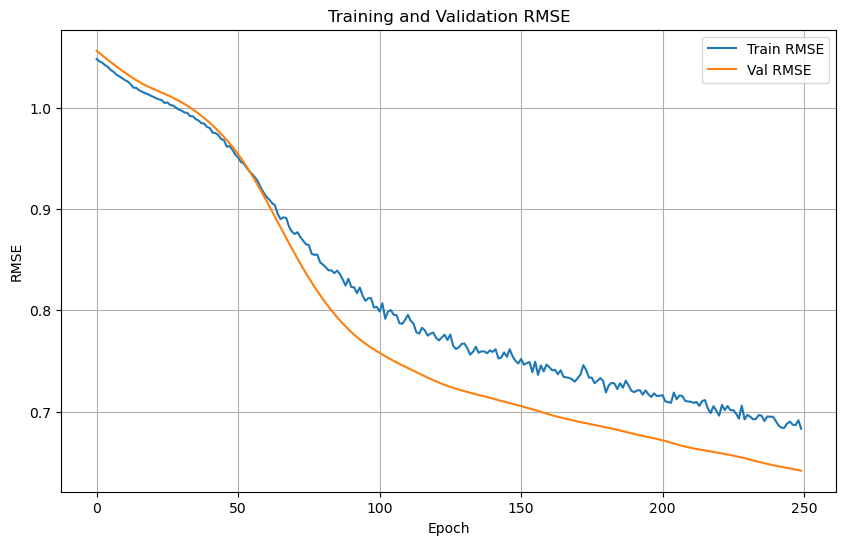

In [25]:
def plot_rmse_history(train_rmse_history, val_rmse_history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(train_rmse_history, label='Train RMSE')
    plt.plot(val_rmse_history, label='Val RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_rmse_history(train_rmse_history, val_rmse_history)

In [26]:
def objective(trial): # the objective function for optuna hyperparameter search
    # Suggest hyperparameters

    lr = trial.suggest_float('lr', 0.0001, 0.01, log=True)
    n_layers = trial.suggest_int('n_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    
    hidden_sizes = [
        trial.suggest_int(f'hidden_size_{i}', 4, 16, 2) for i in range(n_layers)
    ]

    model = MLPRegressor(hidden_sizes, dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    for epoch in range(100):  # Reduce epochs for speed
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = loss_function(val_output, y_val)

    return val_loss.item()


In [31]:
# creating and running the optuna study
study = optuna.create_study(direction='minimize') # minimize because we are using RMSE
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best val loss:", study.best_value)

[I 2025-12-13 16:15:43,878] A new study created in memory with name: no-name-9ece5fae-966c-43b3-9b64-07365ddef307
C:\Users\mamou\AppData\Local\Temp\ipykernel_31236\2440413351.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  trial.suggest_int(f'hidden_size_{i}', 4, 16, 2) for i in range(n_layers)
[I 2025-12-13 16:15:44,010] Trial 0 finished with value: 0.823857307434082 and parameters: {'lr': 0.0005319442001844121, 'n_layers': 3, 'dropout': 0.4307967668369632, 'hidden_size_0': 12, 'hidden_size_1': 4, 'hidden_size_2': 6}. Best is trial 0 with value: 0.823857307434082.
[I 2025-12-13 16:15:44,086] Tria

Best params: {'lr': 0.007641804677901876, 'n_layers': 2, 'dropout': 0.03120790625049938, 'hidden_size_0': 16, 'hidden_size_1': 16}
Best val loss: 0.09861072152853012


Epoch 0: train_loss=1.0241, val_loss=0.9526
Epoch 10: train_loss=0.3413, val_loss=0.3107
Epoch 20: train_loss=0.2107, val_loss=0.1855
Epoch 30: train_loss=0.1786, val_loss=0.1709
Epoch 40: train_loss=0.1637, val_loss=0.1419
Epoch 50: train_loss=0.1533, val_loss=0.1301
Epoch 60: train_loss=0.1461, val_loss=0.1285
Epoch 70: train_loss=0.1394, val_loss=0.1235
Epoch 80: train_loss=0.1396, val_loss=0.1193
Epoch 90: train_loss=0.1278, val_loss=0.1186
Epoch 100: train_loss=0.1241, val_loss=0.1146
Epoch 110: train_loss=0.1207, val_loss=0.1092
Epoch 120: train_loss=0.1148, val_loss=0.1064
Epoch 130: train_loss=0.1136, val_loss=0.0983
Epoch 140: train_loss=0.1023, val_loss=0.0936
Epoch 150: train_loss=0.0991, val_loss=0.0843
Epoch 160: train_loss=0.0945, val_loss=0.0785
Epoch 170: train_loss=0.0882, val_loss=0.0744
Epoch 180: train_loss=0.0872, val_loss=0.0723
Epoch 190: train_loss=0.0819, val_loss=0.0696
Epoch 200: train_loss=0.0789, val_loss=0.0688
Epoch 210: train_loss=0.0756, val_loss=0.0649

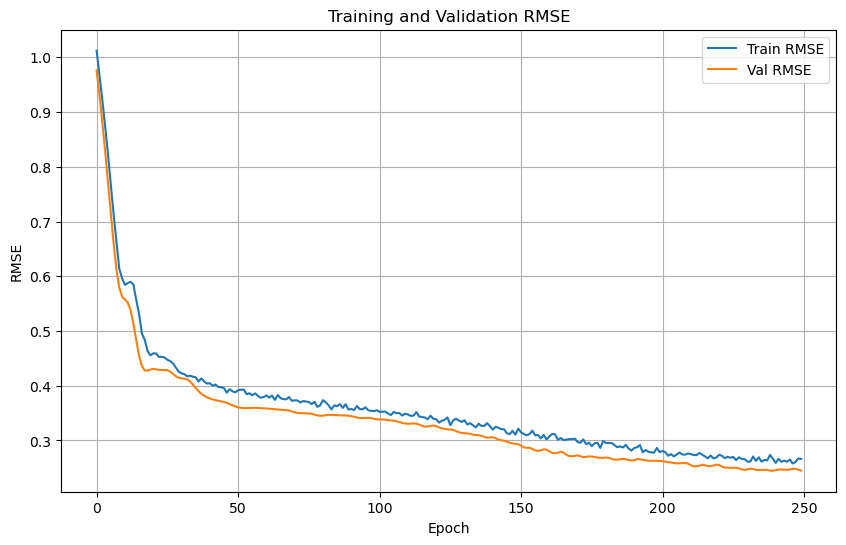

In [32]:
# training the model on the best hyperparameters found

best_params = study.best_params

hidden_sizes = [best_params[f'hidden_size_{i}'] for i in range(best_params['n_layers'])]
dropout_rate = best_params['dropout']
lr = best_params['lr']

train_rmse_history, val_rmse_history = initialize_model_and_train(hidden_sizes, dropout_rate, lr=lr, epochs=250)
plot_rmse_history(train_rmse_history, val_rmse_history)